In [0]:
#Initializing PySpark
from pyspark import SparkContext, SparkConf

In [0]:
conf = SparkConf().setAppName("sample_app")


In [0]:
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions

from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer

In [0]:
sqlContext = SQLContext(sc)


In [0]:

df = sqlContext.read.load('/FileStore/tables/daily_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [0]:
print(df.columns)

['number', 'air_pressure_9am', 'air_temp_9am', 'avg_wind_direction_9am', 'avg_wind_speed_9am', 'max_wind_direction_9am', 'max_wind_speed_9am', 'rain_accumulation_9am', 'rain_duration_9am', 'relative_humidity_9am', 'relative_humidity_3pm']

In [0]:
df = df.drop('number')
df = df.na.drop()

In [0]:
print(df.count(),",",len(df.columns))

1064 , 10

In [0]:
binarizer = Binarizer(threshold=24.99999,
                     inputCol = "relative_humidity_3pm",
                     outputCol = "label")

binarizedDF = binarizer.transform(df)

In [0]:
binarizedDF.toPandas().head(5)

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am,relative_humidity_3pm,label
0,918.060000,74.822000,271.100000,2.080354,295.400000,2.863283,0.0,0.0,42.420000,36.160000,1.0
1,917.347688,71.403843,101.935179,2.443009,140.471548,3.533324,0.0,0.0,24.328697,19.426597,0.0
2,923.040000,60.638000,51.000000,17.067852,63.700000,22.100967,0.0,20.0,8.900000,14.460000,0.0
3,920.502751,70.138895,198.832133,4.337363,211.203341,5.190045,0.0,0.0,12.189102,12.742547,0.0
4,921.160000,44.294000,277.800000,1.856660,136.500000,2.863283,8.9,14730.0,92.410000,76.740000,1.0


In [0]:
binarizedDF.select('relative_humidity_3pm','label').show(5)

+---------------------+-----+
relative_humidity_3pm|label|
+---------------------+-----+
 36.160000000000494| 1.0|
 19.4265967985621| 0.0|
 14.460000000000045| 0.0|
 12.742547353761848| 0.0|
 76.74000000000046| 1.0|
+---------------------+-----+
only showing top 5 rows

In [0]:
binarizedDF.toPandas().head(2)

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,rain_accumulation_9am,rain_duration_9am,relative_humidity_9am,relative_humidity_3pm,label
0,918.060000,74.822000,271.100000,2.080354,295.400000,2.863283,0.0,0.0,42.420000,36.160000,1.0
1,917.347688,71.403843,101.935179,2.443009,140.471548,3.533324,0.0,0.0,24.328697,19.426597,0.0


In [0]:
featureColumns = ['air_pressure_9am','air_temp_9am','avg_wind_direction_9am','avg_wind_speed_9am',
        'max_wind_direction_9am','max_wind_speed_9am','rain_accumulation_9am',
        'rain_duration_9am']
assembler = VectorAssembler(inputCols=featureColumns,
                           outputCol = 'features')

assembled = assembler.transform(binarizedDF)

In [0]:
assembled.select('features').show(2)

+--------------------+
 features|
+--------------------+
[918.060000000008...|
[917.347688117709...|
+--------------------+
only showing top 2 rows

In [0]:
(trainingData, testData) = assembled.randomSplit([0.8,0.2], seed=13234)

In [0]:
trainingData.count(),testData.count()

Out[39]: (846, 218)

In [0]:
dt = DecisionTreeClassifier(labelCol='label',featuresCol='features',maxDepth=5,
                           minInstancesPerNode = 20, impurity = 'gini')

In [0]:
pipeline = Pipeline(stages=[dt])
model = pipeline.fit(trainingData)

In [0]:
predictions = model.transform(testData)

In [0]:
predictions.select('prediction','label').show(5)

+----------+-----+
prediction|label|
+----------+-----+
 1.0| 1.0|
 1.0| 1.0|
 0.0| 1.0|
 1.0| 1.0|
 1.0| 1.0|
+----------+-----+
only showing top 5 rows

In [0]:
assembled.head(2)

Out[44]: [Row(air_pressure_9am=918.0600000000087, air_temp_9am=74.82200000000041, avg_wind_direction_9am=271.1, avg_wind_speed_9am=2.080354199999768, max_wind_direction_9am=295.39999999999986, max_wind_speed_9am=2.863283199999908, rain_accumulation_9am=0.0, rain_duration_9am=0.0, relative_humidity_9am=42.42000000000046, relative_humidity_3pm=36.160000000000494, label=1.0, features=DenseVector([918.06, 74.822, 271.1, 2.0804, 295.4, 2.8633, 0.0, 0.0])),
 Row(air_pressure_9am=917.3476881177097, air_temp_9am=71.40384263106537, avg_wind_direction_9am=101.93517935618371, avg_wind_speed_9am=2.4430092157340217, max_wind_direction_9am=140.47154847112498, max_wind_speed_9am=3.5333236016106238, rain_accumulation_9am=0.0, rain_duration_9am=0.0, relative_humidity_9am=24.328697291802207, relative_humidity_3pm=19.4265967985621, label=0.0, features=DenseVector([917.3477, 71.4038, 101.9352, 2.443, 140.4715, 3.5333, 0.0, 0.0]))]

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [0]:
predictions = sqlContext.read.load('/FileStore/tables/low_humidity_prediction.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol='label',
                                             predictionCol = 'prediction',
                                             metricName = 'accuracy')

In [0]:
acc = evaluator.evaluate(predictions)
print(acc)

0.7844036697247706

In [0]:
predictions.rdd.take(2)

Out[49]: [Row(prediction=1.0, label=1.0), Row(prediction=1.0, label=1.0)]

In [0]:
predictions.rdd.map(tuple).take(5)

Out[50]: [(1.0, 1.0), (1.0, 1.0), (0.0, 1.0), (1.0, 1.0), (1.0, 1.0)]

In [0]:
metrics = MulticlassMetrics(predictions.rdd.map(tuple))

In [0]:
metrics.confusionMatrix().toArray().T

Out[52]: array([[87., 28.],
 [19., 84.]])

In [0]:
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [0]:

df = sqlContext.read.load('/FileStore/tables/daily_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [0]:
df.count()

Out[55]: 1095

In [0]:
df.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
number,1095,547.0,316.24357700987383,0,1094
air_pressure_9am,1092,918.8825513138094,3.184161180386833,907.9900000000024,929.3200000000012
air_temp_9am,1090,64.93300141287072,11.175514003175877,36.752000000000685,98.90599999999992
avg_wind_direction_9am,1091,142.2355107005759,69.13785928889189,15.500000000000046,343.4
avg_wind_speed_9am,1092,5.50828424225493,4.5528134655317185,0.69345139999974,23.554978199999763
max_wind_direction_9am,1092,148.95351796516923,67.23801294602953,28.89999999999991,312.19999999999993
max_wind_speed_9am,1091,7.019513529175272,5.598209170780958,1.1855782000000479,29.84077959999996
rain_accumulation_9am,1089,0.20307895225211126,1.5939521253574893,0.0,24.01999999999907
rain_duration_9am,1092,294.1080522756142,1598.0787786601481,0.0,17704.0


In [0]:
filteredDF = df
filteredDF.filter(filteredDF.rain_accumulation_9am == 0).count()

Out[57]: 964

In [0]:
filteredDF.filter(filteredDF.rain_duration_9am == 0).count()

Out[58]: 908

In [0]:
workingDF = filteredDF.drop('rain_accumulation_9am').drop('rain_duration_9am').drop('hpwren_timestamp')

In [0]:
before = workingDF.count()
workingDF = workingDF.na.drop()
after = workingDF.count()
print(before - after)

22

In [0]:
workingDF.columns

Out[61]: ['number',
 'air_pressure_9am',
 'air_temp_9am',
 'avg_wind_direction_9am',
 'avg_wind_speed_9am',
 'max_wind_direction_9am',
 'max_wind_speed_9am',
 'relative_humidity_9am',
 'relative_humidity_3pm']

In [0]:
featuresUsed = ['air_pressure_9am','air_temp_9am','avg_wind_direction_9am','avg_wind_speed_9am','max_wind_direction_9am',
                'max_wind_speed_9am','relative_humidity_9am']
assembler = VectorAssembler(inputCols=featuresUsed,outputCol='features_unscaled')
assembled = assembler.transform(workingDF)

In [0]:
assembled.show(2)

+------+-----------------+-----------------+----------------------+------------------+----------------------+------------------+---------------------+---------------------+--------------------+
number| air_pressure_9am| air_temp_9am|avg_wind_direction_9am|avg_wind_speed_9am|max_wind_direction_9am|max_wind_speed_9am|relative_humidity_9am|relative_humidity_3pm| features_unscaled|
+------+-----------------+-----------------+----------------------+------------------+----------------------+------------------+---------------------+---------------------+--------------------+
 0|918.0600000000087|74.82200000000041| 271.1| 2.080354199999768| 295.39999999999986| 2.863283199999908| 42.42000000000046| 36.160000000000494|[918.060000000008...|
 1|917.3476881177097|71.40384263106537| 101.93517935618371|2.4430092157340217| 140.47154847112498|3.5333236016106238| 24.328697291802207| 19.4265967985621|[917.347688117709...|
+------+-----------------+-----------------+----------------------+------------------+----------------------+------------------+---------------------+---------------------+--------------------+
only showing top 2 rows

In [0]:
scaler = StandardScaler(inputCol='features_unscaled',outputCol='features',withMean=True,withStd=True)
scalerModel = scaler.fit(assembled)
scalerData = scalerModel.transform(assembled)

In [0]:
scalerData.show(2)

+------+-----------------+-----------------+----------------------+------------------+----------------------+------------------+---------------------+---------------------+--------------------+--------------------+
number| air_pressure_9am| air_temp_9am|avg_wind_direction_9am|avg_wind_speed_9am|max_wind_direction_9am|max_wind_speed_9am|relative_humidity_9am|relative_humidity_3pm| features_unscaled| features|
+------+-----------------+-----------------+----------------------+------------------+----------------------+------------------+---------------------+---------------------+--------------------+--------------------+
 0|918.0600000000087|74.82200000000041| 271.1| 2.080354199999768| 295.39999999999986| 2.863283199999908| 42.42000000000046| 36.160000000000494|[918.060000000008...|[-0.2649387641504...|
 1|917.3476881177097|71.40384263106537| 101.93517935618371|2.4430092157340217| 140.47154847112498|3.5333236016106238| 24.328697291802207| 19.4265967985621|[917.347688117709...|[-0.4890341075136...|
+------+-----------------+-----------------+----------------------+------------------+----------------------+------------------+---------------------+---------------------+--------------------+--------------------+
only showing top 2 rows

In [0]:
scalerData = scalerData.select("features","number")

elbowset = scalerData.filter(scalerData.number % 3 == 0).select("features")
elbowset.persist()

Out[66]: DataFrame[features: vector]

In [0]:
from itertools import cycle, islice
from math import sqrt
from numpy import array
from pyspark.ml.clustering import KMeans as KM
from pyspark.mllib.linalg import DenseVector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def elbow(elbowset, clusters):
	wsseList = []	
	for k in clusters:
		print("Training for cluster size {} ".format(k))
		kmeans = KM(k = k, seed = 1)
		model = kmeans.fit(elbowset)
		transformed = model.transform(elbowset)
		featuresAndPrediction = transformed.select("features", "prediction")
		W = computeCost(featuresAndPrediction, model)
		print("......................WSSE = {} ".format(W))
		wsseList.append(W)
	return wsseList
def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    arrayCollection   = featuresAndPrediction.rdd.map(array)

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)

clusters = range(2,31)

wsseList = elbow(elbowset,clusters)

Training for cluster size 2 
......................WSSE = 736.084225858052 
Training for cluster size 3 
......................WSSE = 641.2094597382217 
Training for cluster size 4 
......................WSSE = 557.339731950257 
Training for cluster size 5 
......................WSSE = 525.5120502508066 
Training for cluster size 6 
......................WSSE = 515.3345300636458 
Training for cluster size 7 
......................WSSE = 485.6659752296685 
Training for cluster size 8 
......................WSSE = 477.43769718355003 
Training for cluster size 9 
......................WSSE = 458.46304870517395 
Training for cluster size 10 
......................WSSE = 443.37006488755486 
Training for cluster size 11 
......................WSSE = 430.5394088668901 
Training for cluster size 12 
......................WSSE = 428.24318378464596 
Training for cluster size 13 
......................WSSE = 414.1019050225905 
Training for cluster size 14 
......................WSSE = 404.2656801635293 
Training for cluster size 15 
......................WSSE = 398.8472524368035 
Training for cluster size 16 
......................WSSE = 393.8671789959912 
Training for cluster size 17 
......................WSSE = 390.2728378220937 
Training for cluster size 18 
......................WSSE = 374.2471129182959 
Training for cluster size 19 
......................WSSE = 379.4863706709139 
Training for cluster size 20 
......................WSSE = 371.5534077328967 
Training for cluster size 21 
......................WSSE = 354.15011664635045 
Training for cluster size 22 
......................WSSE = 355.3540810284125 
Training for cluster size 23 
......................WSSE = 351.0869551735405 
Training for cluster size 24 
......................WSSE = 342.2367807178096 
Training for cluster size 25 
......................WSSE = 341.6922282164048 
Training for cluster size 26 
......................WSSE = 339.67260302281346 
Training for cluster size 27 
......................WSSE = 336.6631724487791 
Training for cluster size 28 
......................WSSE = 342.9149962196101 
Training for cluster size 29 
......................WSSE = 327.5241516754752 
Training for cluster size 30 
......................WSSE = 326.4639663556405

In [0]:
wsseList

Out[68]: [736.084225858052,
 641.2094597382217,
 557.339731950257,
 525.5120502508066,
 515.3345300636458,
 485.6659752296685,
 477.43769718355003,
 458.46304870517395,
 443.37006488755486,
 430.5394088668901,
 428.24318378464596,
 414.1019050225905,
 404.2656801635293,
 398.8472524368035,
 393.8671789959912,
 390.2728378220937,
 374.2471129182959,
 379.4863706709139,
 371.5534077328967,
 354.15011664635045,
 355.3540810284125,
 351.0869551735405,
 342.2367807178096,
 341.6922282164048,
 339.67260302281346,
 336.6631724487791,
 342.9149962196101,
 327.5241516754752,
 326.4639663556405]

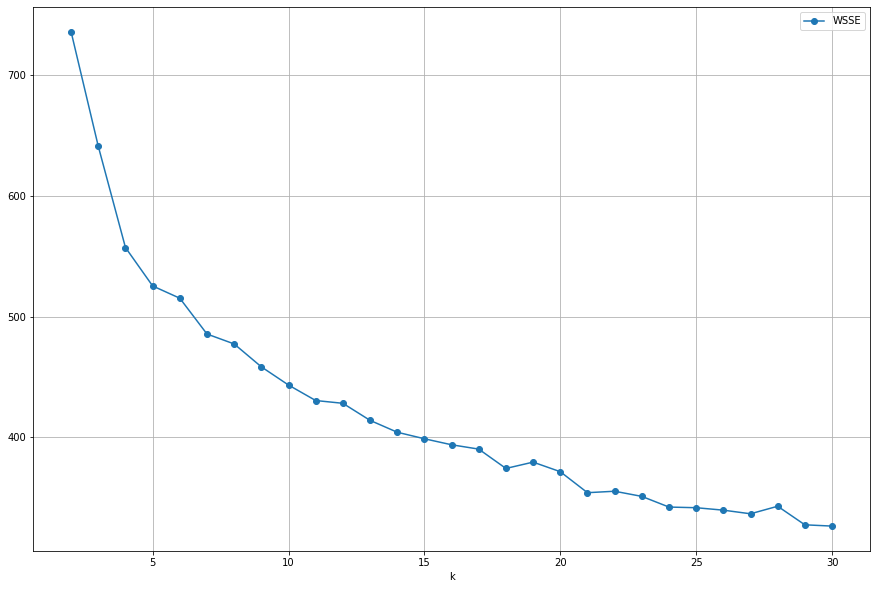

In [0]:
def elbow_plot(wsseList, clusters):
	wsseDF = pd.DataFrame({'WSSE' : wsseList, 'k' : clusters })
	wsseDF.plot(y='WSSE', x='k', figsize=(15,10), grid=True, marker='o')

elbow_plot(wsseList,clusters)

In [0]:
scaledDataFeat = scalerData.select('features')
scaledDataFeat.persist()

Out[71]: DataFrame[features: vector]

In [0]:
kmeans = KMeans(k = 12, seed=1)
model = kmeans.fit(scaledDataFeat)

transformed = model.transform(scaledDataFeat)

In [0]:
centers = model.clusterCenters()
centers

Out[73]: [array([-0.3437111 , 1.13451776, -0.52803217, -0.63982752, -0.88160428,
 -0.62042961, -0.43452677]),
 array([ 1.0745906 , -0.36675083, -1.31342736, 2.56149167, -1.18995072,
 2.62176651, -0.78739248]),
 array([-0.66229141, 0.91527807, 0.73617964, -0.69065603, 0.67359228,
 -0.69260069, -0.23736878]),
 array([ 0.64639832, -0.17179671, -1.06439453, -0.32909003, -1.05487136,
 -0.31995848, -0.59183006]),
 array([ 0.72421992, -1.56147872, 0.83202844, -0.12243376, 0.78432078,
 -0.14788627, 1.57014314]),
 array([-1.24746764, -1.765594 , 0.69712942, 1.30725657, 0.75593404,
 1.22920273, 2.13225072]),
 array([ 1.40039485, -0.05228749, -1.2373987 , 0.77940404, -1.11531321,
 0.81497952, -0.71403425]),
 array([ 0.71749811, 0.14016722, 0.80742838, -0.46066462, 0.90728766,
 -0.4541599 , -0.51981908]),
 array([-0.55243736, -0.94684397, -0.85788946, -0.45669233, -0.99581735,
 -0.42521449, 1.20540207]),
 array([-0.76070489, 0.0074143 , 0.53226792, 0.45136693, 0.61598939,
 0.34496346, -0.02014226]),
 array([ 0.2823252 , -0.11318948, -1.27610963, 1.229208 , -1.14786521,
 1.24152745, -0.55531387]),
 array([-1.00814905, -0.99095531, 0.75534377, -0.44209364, 0.89405874,
 -0.44795241, 1.73174547])]

In [0]:
def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

def parallel_plot(data, P):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(P)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

P = pd_centers(featuresUsed,centers)
P.head()

,air_pressure_9am,air_temp_9am,avg_wind_direction_9am,avg_wind_speed_9am,max_wind_direction_9am,max_wind_speed_9am,relative_humidity_9am,prediction
0,-0.343711,1.134518,-0.528032,-0.639828,-0.881604,-0.620430,-0.434527,0
1,1.074591,-0.366751,-1.313427,2.561492,-1.189951,2.621767,-0.787392,1
2,-0.662291,0.915278,0.736180,-0.690656,0.673592,-0.692601,-0.237369,2
3,0.646398,-0.171797,-1.064395,-0.329090,-1.054871,-0.319958,-0.591830,3
4,0.724220,-1.561479,0.832028,-0.122434,0.784321,-0.147886,1.570143,4


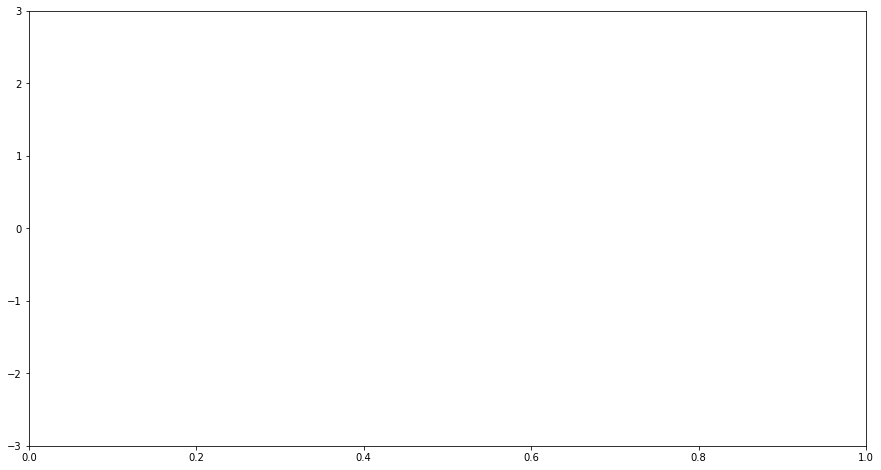

In [0]:
parallel_plot(P.iloc[[2]],P)